In [1]:
# Modules for debugging
'''
import nibabel
from PIL import Image
import os
import fnmatch
import numpy as np
import ants
import concurrent.futures
import pandas as pd
import glob
import xml.etree.ElementTree as ET
import xmltodict
import shutil
import pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D'''

import numpy as np
import open3d as o3d

# Custom modules
from preprocessing_post_fastsurfer.alignment import *
from preprocessing_post_fastsurfer.cropping import *
from preprocessing_post_fastsurfer.extraction import *
from preprocessing_post_fastsurfer.file_handling import *
from preprocessing_post_fastsurfer.mesh_creation import *
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *

np.set_printoptions(precision=2, suppress=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Reference brain
Extract the brain from the MRI reference MRI for use in affine alginment

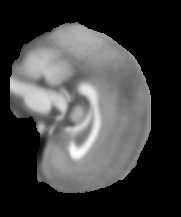

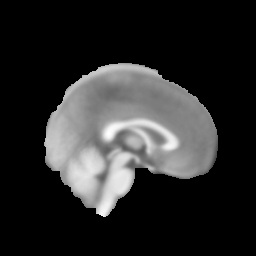

In [2]:
# NB seems that fastsrufer brain is better
reference_brain_array_mni = extract_brain("/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/icbm_avg_152_t1_tal_lin.nii", "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/icbm_avg_152_t1_tal_lin_mask.nii")

display_array(reference_brain_array_mni)

reference_brain_array_fastsurfer = extract_brain("/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/fastsurfer-processed/mri/orig_nu.mgz", "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/mni_icbm152_lin_nifti/fastsurfer-processed/mri/mask.mgz")

display_array(reference_brain_array_fastsurfer)


## Main code

In [3]:
# Initialise a list of subject objects from the given directory
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/adni1-complete-3T-processed"

subject_list = find_subjects_parallel(data_path)

print(len(subject_list))


475


In [ ]:
# Perform affine alignment on all subjects in the list, using the reference brain
alignment_parallel(subject_list, reference_brain_array_fastsurfer)

In [ ]:
# Crop all aligned brains to remove empty space
max_bbox = get_max_bbox(subject_list, 'brain_aligned.nii')

crop_subjects_parallel(subject_list, 'brain_aligned.nii', max_bbox, is_full_brain=True, display_3d=False)

In [ ]:
# Align the parcellation file using the same affine transformation used on the brain
# NB affine alinged aparcs may be inaccurate
aux_alignment_parallel(subject_list, 'aparc', is_aparc=True)

In [ ]:
# Extract left and right hippocampus from non-aligned brains (in the same file)
extract_region_parallel(subject_list, [17, 53], 'orig_nu', 'aparc', is_aligned=False)

In [ ]:
# Crop hippocampi
max_bbox = get_max_bbox(subject_list, 'Left-Hippocampus_Right-Hippocampus.nii')

crop_subjects_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus.nii', max_bbox, is_full_brain=False, display_3d=True)

In [ ]:
# Extract left and right hippocampus from aligned brains (in the same file)
extract_region_parallel(subject_list, [17, 53], 'brain_aligned', 'aparc_aligned', is_aligned=True)

In [ ]:
# Crop hippocampi
max_bbox = get_max_bbox(subject_list, 'Left-Hippocampus_Right-Hippocampus_aligned.nii')

crop_subjects_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus_aligned.nii', max_bbox, is_full_brain=False, display_3d=True)


In [ ]:
# Convert cropped hippocampi point clouds using walking cubes method
volume_to_mesh_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus_cropped.nii', display=False)

In [5]:
# Convert aligned cropped hippocampi point clouds using walking cubes method
volume_to_mesh_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus_aligned_cropped.nii', display=False)

In [10]:
# Delete all non-cropped hippocampi
for subject in subject_list:
    
    delete_file_matching(subject.path, 'Left-Hippocampus_Right-Hippocampus.nii')
    
    delete_file_matching(subject.path, 'Left-Hippocampus_Right-Hippocampus_aligned.nii')

In [ ]:
get_min_cloud_points(subject_list, 'Left-Hippocampus_Right-Hippocampus_cropped_mesh.npz')

In [ ]:
for subject in subject_list[:5]:
    
    display_cloud(downsample_cloud(subject, 'Left-Hippocampus_Right-Hippocampus_cropped_mesh.npz', 2048))

In [1]:
# Downsample all hippocampi clouds to have the same vector size for use in pytorch
downsample_cloud_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus_cropped_mesh.npz', 2048, display=False)

NameError: name 'downsample_cloud_parallel' is not defined

In [ ]:
downsample_cloud_parallel(subject_list, 'Left-Hippocampus_Right-Hippocampus_aligned_cropped_mesh.npz', 2048, display=False)

MCI


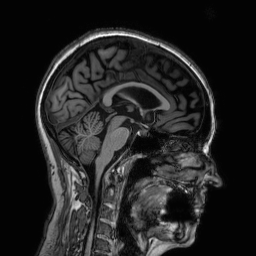

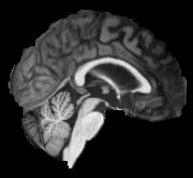

converted image to array


Widget(value='<iframe src="http://localhost:43943/index.html?ui=P_0x7f0b75543680_0&reconnect=auto" class="pyvi…

UnboundLocalError: cannot access local variable 'plotter' where it is not associated with a value

In [ ]:
for subject in subject_list:
    
    research_group = subject.subject_metadata['Group'].iloc[0]
    
    print(research_group)
    
    display_image(nibabel.load(subject.orig_nu))
    
    display_image(nibabel.load(subject.brain_aligned_cropped))
    
    display_image_3d(nibabel.load(subject.brain_aligned_cropped), 1)
    
    display_mesh(np.load(os.path.join(subject.path, 'Left-Hippocampus_Right-Hippocampus_cropped_mesh.npz')))
    
    display_cloud(np.load(os.path.join(subject.path, 'Left-Hippocampus_Right-Hippocampus_cropped_mesh_downsampledcloud.npy')))
    
    break